## Resnet

The **Hypothesis** is RGB takes a relatively large time to train but accuracy gained is minimal.



In [1]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from time import time
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2

from sklearn.metrics import confusion_matrix

### Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [3]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.40, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (30000, 32, 32, 3)
y_train shape: (30000, 1)
X_val shape: (20000, 32, 32, 3)
y_val shape: (20000, 1)


### Data Visualization

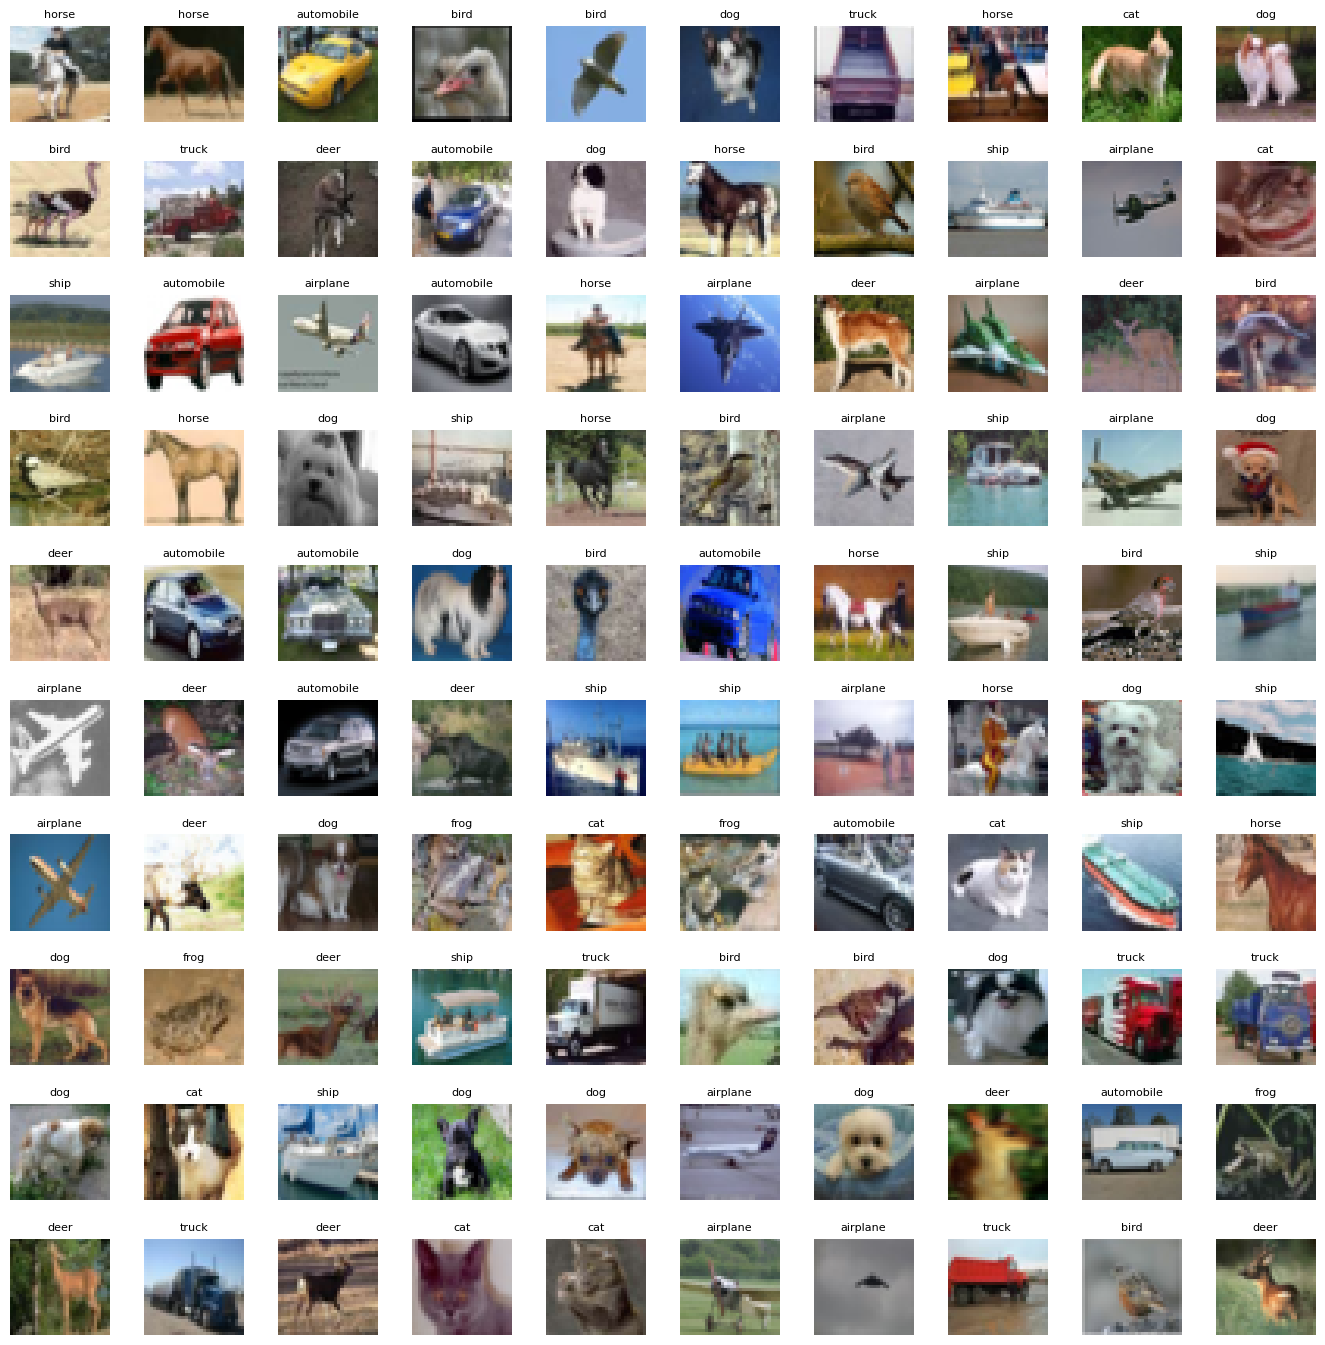

In [4]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17)) #size of each image to be displayed

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the X_train dataset

for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

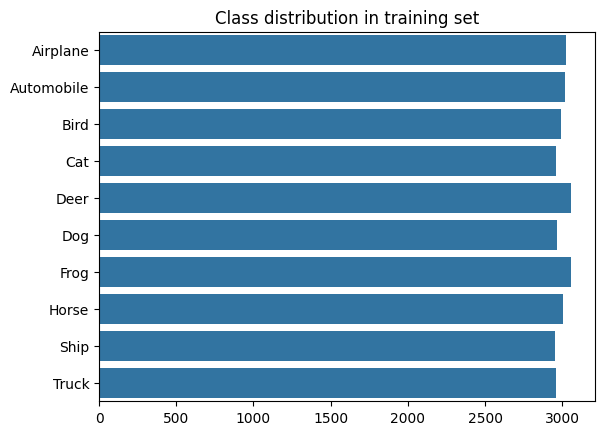

In [5]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

class_, counts = np.unique(y_train, return_counts=True)
sns.barplot(y=class_names, x=counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

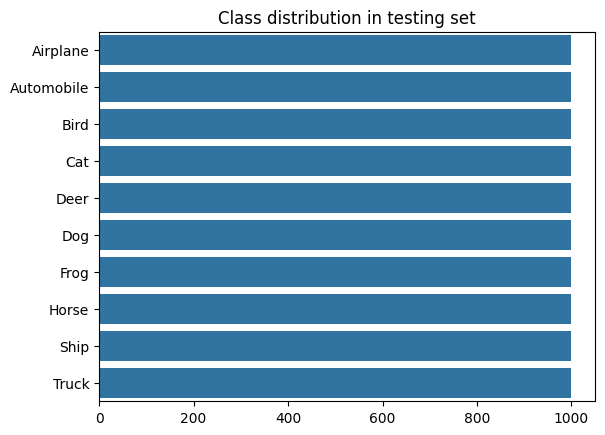

In [6]:
class_, counts = np.unique(y_test, return_counts=True)
sns.barplot(y=class_names, x=counts)
plt.title('Class distribution in testing set')

### Data Preprocessing

In [7]:
# Scale the data by normalizing pixel values
X_train = X_train / 255.0
X_val =X_val / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [8]:
# compute time
class TimingCallback(tf.keras.callbacks.Callback):
 def __init__(self):
   self.logs=[]
 def on_epoch_begin(self, epochs, logs={}):
   self.starttime=time()
 def on_epoch_end(self, epochs, logs={}):
   self.logs.append(time()-self.starttime)

# record time
cbt = TimingCallback()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical



# Define ResNet model
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def resnet(input_shape, num_classes=10):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_blocks_list = [2, 2, 2]  # Number of residual blocks in each stage
    for i, num_blocks in enumerate(num_blocks_list):
        stride = 2 if i > 0 else 1
        x = resnet_block(x, 64, stride=stride)
        for _ in range(num_blocks - 1):
            x = resnet_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

# Create ResNet model
input_shape = X_train.shape[1:]
model = resnet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history10 = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[cbt])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc*100:.2f}%")


Epoch 1/20
938/938 [==============================] - 780s 826ms/step - loss: 1.3611 - accuracy: 0.5064 - val_loss: 1.6734 - val_accuracy: 0.4509
Epoch 2/20
938/938 [==============================] - 775s 826ms/step - loss: 0.9417 - accuracy: 0.6676 - val_loss: 1.3310 - val_accuracy: 0.5602
Epoch 3/20
938/938 [==============================] - 737s 785ms/step - loss: 0.7687 - accuracy: 0.7315 - val_loss: 1.3114 - val_accuracy: 0.5856
Epoch 4/20
938/938 [==============================] - 769s 820ms/step - loss: 0.6460 - accuracy: 0.7763 - val_loss: 1.2853 - val_accuracy: 0.6134
Epoch 5/20
938/938 [==============================] - 766s 817ms/step - loss: 0.5564 - accuracy: 0.8066 - val_loss: 1.0321 - val_accuracy: 0.6546
Epoch 6/20
938/938 [==============================] - 735s 784ms/step - loss: 0.4776 - accuracy: 0.8341 - val_loss: 0.9248 - val_accuracy: 0.6886
Epoch 7/20
938/938 [==============================] - 735s 783ms/step - loss: 0.4081 - accuracy: 0.8585 - val_loss: 0.6573 -

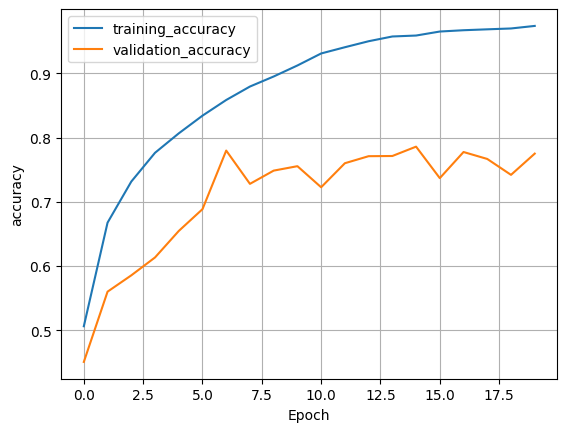

In [10]:
# Plot accuracy chart

def plot_history(history):

   plt.plot(history.history['accuracy'], label='training_accuracy')
   plt.plot(history.history['val_accuracy'], label='validation_accuracy')

   plt.xlabel('Epoch')
   plt.ylabel('accuracy')
   plt.grid(True)

   plt.legend()
   plt.show()


plot_history(history10)

In [11]:
# training & validation accuracy data table

epoch_time = pd.Series(cbt.logs)
table=pd.DataFrame(history10.history)
table['epoch_time'] = epoch_time.values


In [14]:
table[['accuracy', 'val_accuracy', 'epoch_time']] # accuracy = training accuracy

,accuracy,val_accuracy,epoch_time
0,0.506367,0.45085,779.539806
1,0.667600,0.56020,774.713609
2,0.731533,0.58560,736.573137
3,0.776333,0.61345,768.722180
4,0.806567,0.65465,766.262269
5,0.834133,0.68860,734.884995
6,0.858533,0.77980,734.587413
7,0.879467,0.72800,766.570070
8,0.895100,0.74860,765.899680
9,0.912233,0.75550,736.951469


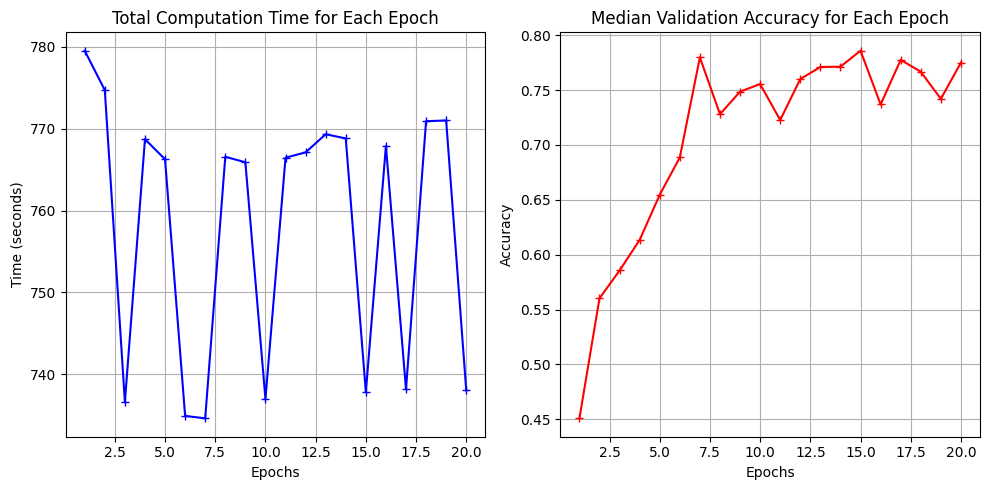

In [15]:
# chart or median processing time per epoch and median validation accuracy per epoch

epochs = np.arange(1, 21) # 20 epochs


# Plotting total computation time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, table.epoch_time, marker='+', linestyle='-', color='b')
plt.title('Total Computation Time for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.grid(True)


# Plotting median validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, table.val_accuracy, marker='+', linestyle='-', color='r')
plt.title('Median Validation Accuracy for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)


plt.tight_layout()
plt.show()

In [16]:
median_processing_time = np.median(table.epoch_time)
print(f"Median Processing Time per Epochs: {median_processing_time:.2f} seconds")

Median Processing Time per Epochs: 766.51 seconds


In [18]:
median_validation_accuracy = np.median(table.val_accuracy)
print(f"Median Validation Accuracy per Epochs: {median_validation_accuracy*100:.2f} %")

Median Validation Accuracy per Epochs: 74.53 %
